# DQN, Deep Q Learning

In [1]:
import os
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import gymnasium as gym

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [7]:
MEMORY_SIZE = int(1e4)
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 200

## Set Environment

In [8]:
ENV_NAME = 'CartPole-v1'
env = gym.make(ENV_NAME, render_mode="rgb_array")

Environment Display:


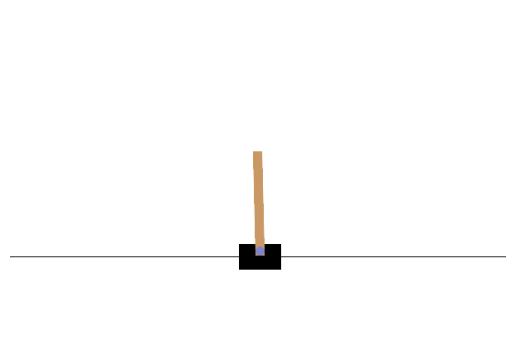

State space Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space Discrete(2)


In [9]:
print('Environment Display:')

# Reset the environment to get the initial state
obs = env.reset()

# Render the initial frame
frame = env.render()

# Display the frame using Matplotlib
plt.imshow(frame)
plt.axis('off')
plt.show()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

## Build DQN Architecture

In [10]:
class DQN(nn.Module):
    """Define DQN architecture."""

    def __init__(self, screen_height, screen_width, n_actions):
        super(DQN, self).__init__()

        # Calculate input channels based on screen height and width
        input_channels = 12 # Assuming RGB input stacked 4 times

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(self._conv_output_size(screen_height, screen_width), 128)
        self.fc2 = nn.Linear(128, n_actions)

        # Activation function
        self.relu = nn.ReLU()

    def _conv_output_size(self, h, w):
        
        # Calculate the output size after convolutional layers
        x = torch.rand(1, 12, h, w)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        return x.view(1, -1).size(1)

    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU activation
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

## Set Replay Memory

In [11]:
Transition = namedtuple('Transition', 
                       ('state', 'action', 'next_state', 'reward'))

In [12]:
# a method for selecting a random batch of transitions for training
class ReplayMemory(object):
    """Fixed-size memory to store experience tuples."""
    
    def __init__(self, capacity):
        
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    # *args filled by state, action, next_state and reward variables
    def push(self, *args):
        """Add a new experience to memory."""
        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [13]:
memory = ReplayMemory(MEMORY_SIZE) # init capacity

## Extract Input

In [14]:
# using transforms from PyTorch to resize the screen
resize = T.Compose([T.ToPILImage(),
                    T.Resize((40, 80), interpolation=Image.BICUBIC),
                    T.ToTensor()])

In [15]:
def get_cart_location(screen_width):
    
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    cart_location = int(env.state[0] * scale + screen_width / 2.0)
    
    return cart_location

In [16]:
def get_screen():
    
    # returned screen requested by gym is 800x1200x3, but sometimes smaller or larger
    # this will transpose it into torch order (C, H, W)
    screen = env.render().transpose((2, 0, 1))
    
    # cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height*0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    
    if (cart_location < view_width // 2):
        slice_range = slice(view_width)
    elif (cart_location > (screen_width - view_width // 2)):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
        
    # strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    
    # convert to float, rescale, convert to torch tensor
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    # resize and add a batch dimension (B, C, H, W)
    return resize(screen).unsqueeze(0).to(device)

## Init Screen

In [17]:
# get screen size so that we can initialize layers correctly based on the shape
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

## Initialize DQN

In [18]:
# get number of actions from gym action space
n_actions = env.action_space.n

dqn_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(dqn_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(12, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)

## Set Optimizer

In [19]:
optimizer = optim.RMSprop(dqn_net.parameters())

## Train DQN

In [20]:
steps_done = 0

# this will select an action accordingly to an epsilon greedy policy
def select_action(state):
    
    global steps_done

    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return dqn_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long, device=device)

In [21]:
episode_durations = []

# a helper for plotting the durations of episodes and rewards
def plot_durations(i_episode, num_episodes, episode_rewards):
    if i_episode < 100:
        return

    plt.figure(figsize=(10, 7))
    plt.clf()

    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    plt.title(f'Training Episode: {i_episode}')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Rewards')

    # Compute the average reward and standard deviation
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        stds = rewards_t.unfold(0, 100, 1).std(1).view(-1)
        stds = torch.cat((torch.zeros(99), stds))

        # Plot average reward and standard deviation
        plt.plot(means.numpy(), color='red', label='Average Reward (All)')
        plt.fill_between(range(len(means)), means - stds, means + stds, color='red', alpha=0.3, label='Standard Deviation (All)')
    
    plt.legend()
    plt.grid(True)
    plt.savefig('./images/plot_of_training_result_cnn_dqn.png')
    plt.pause(0.001)

    if is_ipython and i_episode is not num_episodes:
        display.clear_output(wait=True)
        plt.show()
    else:
        return

In [22]:
# this function first samples a batch, concatenates all the tensors into a single one
# then computes Q(st, at) and V(st+1) = maxaQ(st+1, a), and combines them into our loss
def optimize_network():
    if len(memory) < BATCH_SIZE: return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), dtype=torch.bool, device=device)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    Q_target = reward_batch + (GAMMA * next_state_values)

    Q_expected = dqn_net(state_batch).gather(1, action_batch)

    loss = F.smooth_l1_loss(Q_expected, Q_target.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in dqn_net.parameters():
        param.grad.data.clamp_(-1, 1)
    
    optimizer.step()

In [23]:
def get_state(stack_frames):
    return torch.cat(list(stack_frames), dim=1).to(device)

def train_network(num_episodes):
    num_stack_frames = 4  # Number of frames to stack
    stack_frames = deque(maxlen=num_stack_frames)
    episode_rewards = []

    for i_episode in range(1, num_episodes+1):
        env.reset()
        last_screen = get_screen()
        
        for _ in range(num_stack_frames):
            stack_frames.append(last_screen)

        state = get_state(stack_frames)
        total_reward = 0  # Track total reward for the episode

        for time_step in count():
            action = select_action(state)
            _, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            total_reward += reward.item()  # Add reward to total reward

            current_screen = get_screen()
            stack_frames.append(current_screen)
            next_state = get_state(stack_frames) if not terminated else None

            memory.push(state, action, next_state, reward)
            state = next_state
            optimize_network()

            if terminated or truncated:
                episode_durations.append(time_step + 1)
                episode_rewards.append(total_reward)  # Save total reward for the episode
                plot_durations(i_episode, num_episodes, episode_rewards)
                break

            if steps_done % 100 == 0:
                target_net.load_state_dict(dqn_net.state_dict())

    torch.save(dqn_net.state_dict(), f'./agents/CNN_DQN_{ENV_NAME}.pth')
    print('Training completed.')
    env.render()
    env.close()
    plt.show()

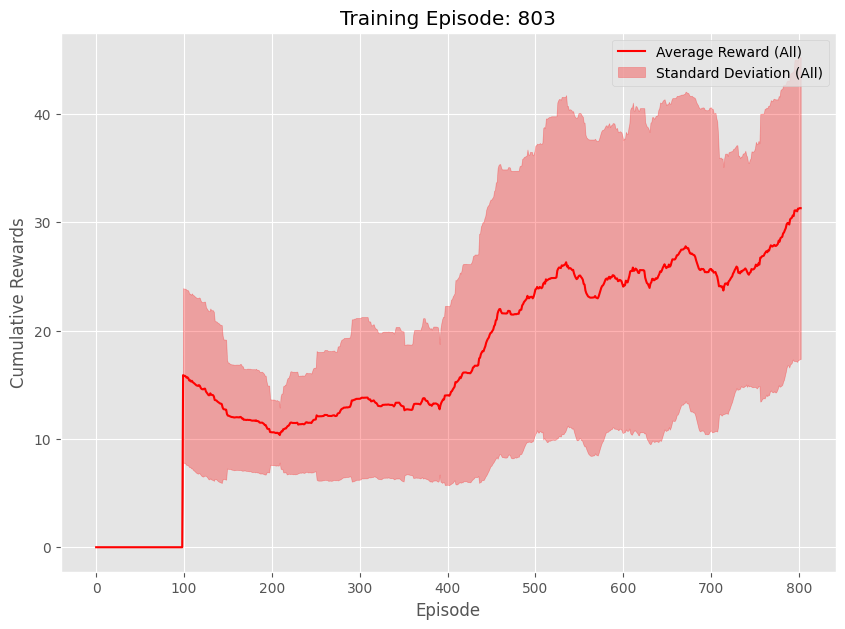

In [ ]:
print('Training the network...')
train_network(num_episodes=20000)

---